<a href="https://colab.research.google.com/github/dwahast/Deep-learning/blob/master/CNN_MLP_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivos deste trabalho
- Familiarizar-se com a biblioteca PyTorch
- Definir arquiteturas MLP simples em PyTorch
- Treinar utilizando CIFAR10, testando diferentes arquiteturas, parâmetros, funções de loss e otimizadores
- Comparar os resultados obtidos utilizando apenas Perpceptrons
- Link útil (https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c)

In [1]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import torch.nn.functional as F # softmax/relu

print(torch.cuda.is_available())


True


In [2]:
# Carregar os datasets

#transform=transforms.Compose([
#    transforms.Grayscale(num_output_channels=1),
#    transforms.ToTensor()
#])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
])

#normaliza o dataset de test mas sem data augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_loader = DataLoader(dataset=dataset_train, shuffle=True, batch_size=32) #define de Batch_size of the training
test_loader = DataLoader(dataset=dataset_test, shuffle=False, batch_size=4)
print(len(test_loader))

dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.size())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

2500
torch.Size([32, 3, 32, 32])
cuda:0


In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv_layer = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,stride=1, padding=1),
          nn.BatchNorm2d(32),   
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout2d(p=0.05),

          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          )  
        
        self.fc_layers = nn.Sequential(
            
          #Flatten the feature maps. You have 32 feature mapsfrom cnn2. Each of the feature is of size 16x16 --> 32*16*16 = 8192
          #nn.Dropout(p=0.1),    #Dropout used to reduce overfitting 
          #nn.Linear(32*32*4, 1024),   #Flattened image is fed into linear NN and reduced to half size
          #nn.ReLU(inplace=True),
          #nn.Linear(1024, 256),
          #nn.ReLU(inplace=True),
          #nn.Linear(256, 64),
          #nn.Dropout(p=0.1),
          #nn.Linear(64, 10),
          #nn.Linear(10,10)  #Since there were so many features, I decided to use 45 layers to get output layers. You can increase the kernels in Maxpooling to reduce image further and reduce number of hidden linear layers.
          nn.Dropout(p=0.1),
          nn.Linear(4096, 1024),
          nn.ReLU(inplace=True),
          nn.Linear(1024, 512),
          nn.ReLU(inplace=True),
          nn.Dropout(p=0.1),
          nn.Linear(512, 10)
        )
        
    def forward(self,x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [0]:
# Definir a arquitetura MLP
# New Arquitecture with RELU   
class MLP_Srelu(nn.Module):
    def __init__(self):
        super(MLP_Srelu, self).__init__()
        self.fc1 = nn.Linear(32*32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 10)
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x),dim =1)
        return x   


In [0]:
model_CNN = CNN()
model_CNN = model_CNN.to(device)

In [0]:
# Definir otimizador e loss
# Nota: testar outros otimizadores e funções de loss (em particular cross entropy)

def optimizer_set(model,optimizer_method, learning_rate):
  if optimizer_method == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
  elif optimizer_method == "adadelta":
    optimizer = torch.optim.Adadelta(model.parameters(), lr = learning_rate)
  elif optimizer_method == "adagrad":
    optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
  elif optimizer_method == "adamax":
    optimizer = torch.optim.Adamax(model.parameters(), lr = learning_rate)
  elif optimizer_method == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)  
  elif optimizer_method == "rms":
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
  return optimizer

def loss_function_set(loss_function):
  if loss_function == "mse":
    loss_fn = torch.nn.MSELoss()
  elif loss_function == "nllos":
     loss_fn = torch.nn.NLLoss()
  elif loss_function == "cross":
     loss_fn = torch.nn.CrossEntropyLoss()
  return loss_fn
  

In [0]:
def one_hot(label, output_size):
    
    label_select = np.zeros(output_size)
    label_select[label]=1
    
    return torch.Tensor(label_select)

In [0]:
def evaluate(model, loss_function, dataset):
  model.eval() # set model to Evaluate "mode"
  losses = []
  corrects = 0
  current_total = 0
  accuracies = 0
  loss_fn = loss_function_set(loss_function)
  
  for image, label in dataset:
    image = image.to(device)
    label = label.to(device)
    outputs = model(image)
    losses.append(loss_fn(outputs, label).item())
    
    _, predicted = outputs.max(1)
    current_total += label.size(0)
    corrects += predicted.eq(label).sum().item()
    
    current_total += 1
  
  accuracy = corrects/current_total

  return accuracy, np.mean(losses)
      

#Training function

In [0]:
# Realizar o treinamento aqui
def fit(model, epochs, optimizer_method, loss_function, learning_rate):
  
  print("Opt Method:", optimizer_method.upper(), "| Loss Function:", loss_function.upper(), "| Learning Rate:", learning_rate)
  optimizer = optimizer_set(model,optimizer_method, learning_rate) #optimizer and Learning rate setter
  loss_fn = loss_function_set(loss_function) 
  test_accuracies = []
  test_losses = []
  train_losses = []
  train_accuracies = []
  for epoch in range(epochs):
    total = 0
    corrects = 0
    model.train() # Set model to TRAIN "mode" (can be set to False for Test)
    epoch_losses = []
    for image,label in train_loader:
      image, label = image.to(device), label.to(device) 
      optimizer.zero_grad()  # cleaning gradients between mini batches
      outputs = model(image) 
      
      if(loss_function == 'mse'):
        label_target = one_hot(label,10) # one_hot to set the training class in the escalar
        loss = loss_fn(outputs,label_target)
      else: 
        loss = loss_fn(outputs, label)
        
      loss.backward() # Backpropagation 
      optimizer.step() # Optimization Method
      epoch_losses.append(loss.item())
      total += label.size(0)
      _, predicted = torch.max(outputs.data, 1)
      corrects += (predicted==label).sum().item()
      
    train_losses.append(np.mean(epoch_losses)) # Append mean losses for each epoch
    train_accuracies.append(corrects/total)
    

    acc, lss = evaluate(model, loss_function, test_loader) #evaluate
    test_accuracies.append(acc)
    test_losses.append(lss)
    
    print("Epoch:",epoch, "- Loss:", test_losses[-1],"- Accuracy:", acc) # Print mean Loss for each epoch
 
  return {
      "Model": outputs,
      "Test Acc": test_accuracies,
      "Test Loss": test_losses,
      "Train Acc": train_accuracies,
      "Train Loss": train_losses,
      "Name": optimizer_method + " | " + loss_function + " | " + str(learning_rate),
      "Arc": model
      
  }

# Training Your Model
- Variable "trained_models" append all models trained
- function "fit" train and return the Model and the all variable that will be used latter
  - *fit(Model, Epochs, Optimizer method, Loss function, Learning rate)*

In [11]:
trained_models = []
ep = 100 #epocas
trained_models.append(fit(model_CNN, ep,"adam", "cross", 0.0015))


Opt Method: ADAM | Loss Function: CROSS | Learning Rate: 0.0015
Epoch: 0 - Loss: 1.481995992088318 - Accuracy: 0.36496
Epoch: 1 - Loss: 1.1132677952528 - Accuracy: 0.47232
Epoch: 2 - Loss: 0.9622948179125785 - Accuracy: 0.52392
Epoch: 3 - Loss: 0.8893221819996834 - Accuracy: 0.552
Epoch: 4 - Loss: 0.7750752312541008 - Accuracy: 0.58496
Epoch: 5 - Loss: 0.7149577456951142 - Accuracy: 0.60536
Epoch: 6 - Loss: 0.789842614710331 - Accuracy: 0.58984
Epoch: 7 - Loss: 0.6380771070837975 - Accuracy: 0.62816
Epoch: 8 - Loss: 0.61967817414999 - Accuracy: 0.62848
Epoch: 9 - Loss: 0.593951693546772 - Accuracy: 0.63992
Epoch: 10 - Loss: 0.6112634649693965 - Accuracy: 0.63712
Epoch: 11 - Loss: 0.5474534886240959 - Accuracy: 0.65224
Epoch: 12 - Loss: 0.5482357247412205 - Accuracy: 0.65184
Epoch: 13 - Loss: 0.5572475960075856 - Accuracy: 0.65064
Epoch: 14 - Loss: 0.5306338617742061 - Accuracy: 0.66008
Epoch: 15 - Loss: 0.5054598715007305 - Accuracy: 0.6656
Epoch: 16 - Loss: 0.541495920920372 - Accurac

In [12]:
model_CNN = CNN().to(device)
trained_models.append(fit(model_CNN, ep,"rms", "cross", 0.00173))

Opt Method: RMS | Loss Function: CROSS | Learning Rate: 0.00173
Epoch: 0 - Loss: 1.5932175261259078 - Accuracy: 0.32664
Epoch: 1 - Loss: 1.2596313846230507 - Accuracy: 0.4392
Epoch: 2 - Loss: 1.5692159962534904 - Accuracy: 0.43208
Epoch: 3 - Loss: 0.8597221885055304 - Accuracy: 0.55656
Epoch: 4 - Loss: 0.9502126963704824 - Accuracy: 0.54512
Epoch: 5 - Loss: 0.7561928114559502 - Accuracy: 0.59288
Epoch: 6 - Loss: 0.7274344754852354 - Accuracy: 0.60328
Epoch: 7 - Loss: 0.6979773954384029 - Accuracy: 0.6108
Epoch: 8 - Loss: 0.876878445103392 - Accuracy: 0.58272
Epoch: 9 - Loss: 0.755106009766832 - Accuracy: 0.6048
Epoch: 10 - Loss: 0.5654350429558195 - Accuracy: 0.65048
Epoch: 11 - Loss: 0.5695589543119073 - Accuracy: 0.65312
Epoch: 12 - Loss: 0.6198518155530095 - Accuracy: 0.63192
Epoch: 13 - Loss: 0.5299655817031861 - Accuracy: 0.66432
Epoch: 14 - Loss: 0.6027637143552304 - Accuracy: 0.64832
Epoch: 15 - Loss: 0.5505334466159344 - Accuracy: 0.6564
Epoch: 16 - Loss: 0.5775251268208027 - A

In [16]:
model_CNN = CNN().to(device)
trained_models.append(fit(model_CNN, ep,"adagrad", "cross", 0.001))

Opt Method: ADAGRAD | Loss Function: CROSS | Learning Rate: 0.001
Epoch: 0 - Loss: 1.2182768869042397 - Accuracy: 0.44744
Epoch: 1 - Loss: 1.0222770299315453 - Accuracy: 0.50672
Epoch: 2 - Loss: 0.9373530644893646 - Accuracy: 0.53312
Epoch: 3 - Loss: 0.8897220006942749 - Accuracy: 0.54184
Epoch: 4 - Loss: 0.8389010432600975 - Accuracy: 0.5608
Epoch: 5 - Loss: 0.8101743170261383 - Accuracy: 0.56792
Epoch: 6 - Loss: 0.7801667033672333 - Accuracy: 0.58104
Epoch: 7 - Loss: 0.7550921332359314 - Accuracy: 0.58616
Epoch: 8 - Loss: 0.7297330267429352 - Accuracy: 0.59464
Epoch: 9 - Loss: 0.706896882712841 - Accuracy: 0.59856
Epoch: 10 - Loss: 0.7060070345401764 - Accuracy: 0.60128
Epoch: 11 - Loss: 0.6887372393846511 - Accuracy: 0.60792
Epoch: 12 - Loss: 0.6755311264157295 - Accuracy: 0.60992
Epoch: 13 - Loss: 0.6742676539063454 - Accuracy: 0.61216
Epoch: 14 - Loss: 0.6519390713214874 - Accuracy: 0.61584
Epoch: 15 - Loss: 0.6476036030888558 - Accuracy: 0.61728
Epoch: 16 - Loss: 0.63403460338115

In [17]:
model_CNN = CNN().to(device)
trained_models.append(fit(model_CNN, ep,"rms", "cross", 0.00087))

Opt Method: RMS | Loss Function: CROSS | Learning Rate: 0.00087
Epoch: 0 - Loss: 1.3182448090076446 - Accuracy: 0.40944
Epoch: 1 - Loss: 1.202674794882536 - Accuracy: 0.47096
Epoch: 2 - Loss: 0.981557168918848 - Accuracy: 0.52728
Epoch: 3 - Loss: 0.8494212203204632 - Accuracy: 0.55888
Epoch: 4 - Loss: 0.7634793020129204 - Accuracy: 0.58808
Epoch: 5 - Loss: 0.8994640011891722 - Accuracy: 0.56272
Epoch: 6 - Loss: 0.6520618886351586 - Accuracy: 0.62488
Epoch: 7 - Loss: 0.5994547662902623 - Accuracy: 0.63968
Epoch: 8 - Loss: 0.6353560434438288 - Accuracy: 0.63776
Epoch: 9 - Loss: 0.5923691158313305 - Accuracy: 0.64456
Epoch: 10 - Loss: 0.5849137077524327 - Accuracy: 0.63824
Epoch: 11 - Loss: 0.510966598080378 - Accuracy: 0.66472
Epoch: 12 - Loss: 0.8273989022591152 - Accuracy: 0.61136
Epoch: 13 - Loss: 0.5047090137894731 - Accuracy: 0.66992
Epoch: 14 - Loss: 0.5544006018149666 - Accuracy: 0.65424
Epoch: 15 - Loss: 0.5051148371681571 - Accuracy: 0.67464
Epoch: 16 - Loss: 0.6074357362888754 

# Text and Graphical Output

In [0]:
def graphical_outputs(trained_models):
  
  plt.figure(1)
  plt.title("\n\nAccuracy " + trained_models[0]["Name"].upper() +"\n", fontsize=20, loc="left")
  plt.title("dotted line = train")
  for models in trained_models:
    plt.plot(models["Test Acc"], label = str(models["Name"]).partition("|")[0] + + str(models["Name"]).partition("|")[3])
    plt.plot(models["Train Acc"],"--") 
    print(models["Arc"],"\nModel Mean ACC:", np.mean(models["Test Acc"]),"\nModel Last ACC:", models["Test Acc"][-1])

  plt.legend(loc='best')
  plt.show
  
  plt.figure(2)
  plt.title("\n\nLosses " + trained_models[0]["Name"].upper() +"\n", fontsize=20, loc="left")
  plt.title("dotted line = train")
  for models in trained_models:
    plt.plot(models["Test Loss"], label = str(models["Name"]).partition("|")[0] + str(models["Name"]).partition("|")[3])
    plt.plot(models["Train Loss"],"--") 
    print("\nModel Mean Loss:", np.mean(models["Test Loss"]),"\nModel Last Loss:", models["Test Loss"][-1])

  plt.legend(loc='best')
  plt.show


CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU(inplace)
   

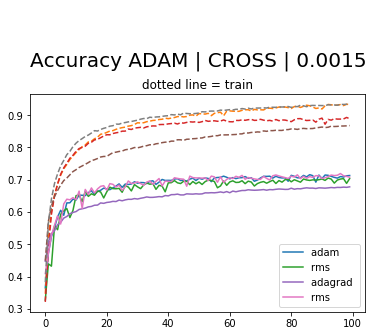

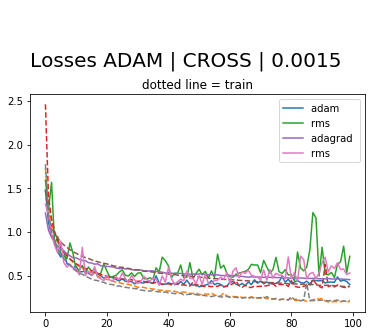

In [19]:
graphical_outputs(trained_models)